In [31]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [32]:
TRAIN_DIR = 'UCI HAR Dataset/train'
TEST_DIR = 'UCI HAR Dataset/test'

def read_a_file(file):
    """
    read_a_file: Read the data file, Each row is corresponding to one subject's motion. 
    file: the file path
    
    """
    f = open(file, 'r', encoding='utf-8')
    data = []
    for line in f:
        line = line.strip().split()
        x = [float(v) for v in line]
        data.append(x)
    f.close()
    data = np.array(data)
    return data

In [33]:
def read_dataset(data_dir):
    """
    read_dataset: Read X and y form 'UCI HAR Dataset/train' or 'UCI HAR Dataset/test' . The returned X and y are used
    as training or testing data set.

    data_dir: file address 'UCI HAR Dataset/train' or 'UCI HAR Dataset/test'
     X (A n * f matrix,where n is the number of samples, f is the number of features),
     y (A n*1 matrix where n is corresponding to the number of labels)
    """
    kind = 'train' if 'train' in data_dir else 'test'

    # X has 2 parts: for train, it comes form X_train.txt, and Inertial Signals
    # Part 1. X_train.txt or X_test.txt
    X1 = read_a_file(os.path.join(data_dir, 'X_{}.txt'.format(kind)))
    print('The data shape of X_{}.txt is {} × {}'.format(kind, X1.shape[0], X1.shape[1]))

    
    # Part 2. Inertial Signals
    # IS_dir = os.path.join(data_dir, 'Inertial Signals')
    # X2 = []
    # for file_name in os.listdir(IS_dir):
    #     file_path = os.path.join(IS_dir, file_name)
    #     tmp = read_a_file(file_path)
    #     X2.append(tmp)
    # X2 = np.concatenate(X2, axis=1)
    # print('The data shape of Inertial Signals is {} × {}'.format(X2.shape[0], X2.shape[1]))

    # X = np.concatenate([X1, X2], axis=1)
    
    X = X1
  
    # Read the y data
    y = read_a_file(os.path.join(data_dir, 'y_{}.txt'.format(kind)))
    y = np.array(y.reshape(-1)) - 1
    return X, y

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(561, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 6)
    
    def forward(self, x):
        x = x.view(-1, 561)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
#data process
#train data
X_train, y_train = read_dataset(TRAIN_DIR)
print()

The data shape of X_train.txt is 7352 × 561



The data shape of X_train.txt is 7352 × 561

epoch: 1: loss: 0.102
epoch: 2: loss: 0.054
epoch: 3: loss: 0.042
epoch: 4: loss: 0.033
epoch: 5: loss: 0.030
epoch: 6: loss: 0.024
epoch: 7: loss: 0.023
epoch: 8: loss: 0.019
epoch: 9: loss: 0.024
epoch: 10: loss: 0.018


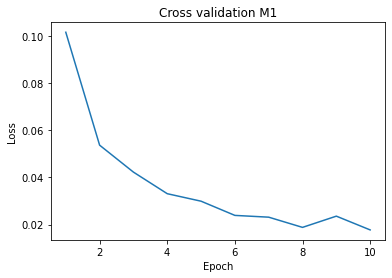

epoch: 1: loss: 0.096
epoch: 2: loss: 0.051
epoch: 3: loss: 0.039
epoch: 4: loss: 0.032
epoch: 5: loss: 0.029
epoch: 6: loss: 0.028
epoch: 7: loss: 0.025
epoch: 8: loss: 0.020
epoch: 9: loss: 0.017
epoch: 10: loss: 0.018


<Figure size 432x288 with 0 Axes>

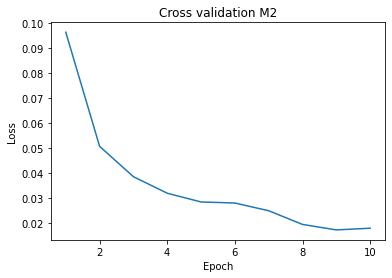

epoch: 1: loss: 0.092
epoch: 2: loss: 0.050
epoch: 3: loss: 0.041
epoch: 4: loss: 0.032
epoch: 5: loss: 0.029
epoch: 6: loss: 0.027
epoch: 7: loss: 0.024
epoch: 8: loss: 0.021
epoch: 9: loss: 0.018
epoch: 10: loss: 0.019


<Figure size 432x288 with 0 Axes>

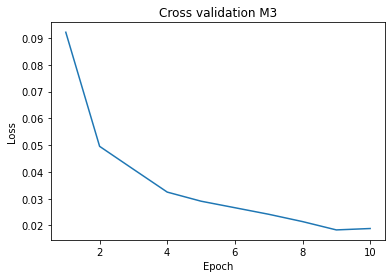

epoch: 1: loss: 0.095
epoch: 2: loss: 0.051
epoch: 3: loss: 0.040
epoch: 4: loss: 0.035
epoch: 5: loss: 0.032
epoch: 6: loss: 0.028
epoch: 7: loss: 0.025
epoch: 8: loss: 0.027
epoch: 9: loss: 0.019
epoch: 10: loss: 0.019


<Figure size 432x288 with 0 Axes>

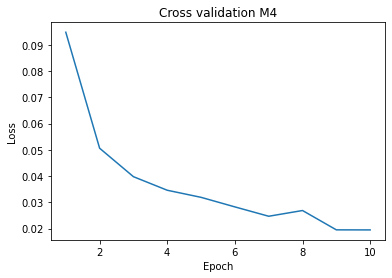

<Figure size 432x288 with 0 Axes>

In [36]:
#data process
#train data
X_train, y_train = read_dataset(TRAIN_DIR)
print()
#Reset the labels as 0 an 1
for i in range(len(y_train)):
    if y_train[i] <= 3:
        y_train[i] = 0
    else:
        y_train[i] = 1

#train the model with cross validation

#choose Cross Entropy Loss as the loss function 
criterion = nn.CrossEntropyLoss()
#choose Stochastic Gradient Descent to updated parameters.
#set the learning rate to 0.001; set the momentum to 0.9 which may help jump out of local optimum



best_acc = 0
for k in range(4):
    net = Net()#    
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #lr is the learning rate
    
    loss_arr = np.zeros(10)
    idx = np.zeros(7352, dtype=np.bool)
    idx[1838*k:1838*(k+1)] = True
    X_v = torch.tensor(X_train[idx], dtype=torch.float32)  #transfer numpy to tensor
    y_v = torch.tensor(y_train[idx], dtype=torch.long)  
    idx = (1 - idx).astype(bool)
    X_t = torch.tensor(X_train[idx], dtype=torch.float32) 
    y_t = torch.tensor(y_train[idx], dtype=torch.long)  

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_t, y_t), batch_size=16, shuffle=True)
    validate_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_v, y_v), batch_size=16, shuffle=True)
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            optimizer.zero_grad()#initialize the gradient of each variable
            outputs = net(inputs) #forward-propagating process
            loss = criterion(outputs, labels) #compute the loss function
            loss.backward()  #back-propagation
            optimizer.step() #update the parameters
            
            running_loss += loss.item()
        loss_arr[epoch] = running_loss / 1838
        print('epoch: %d: loss: %.3f' %(epoch + 1, running_loss / 1838))
        
 #log loss function for plotting   
    plt.figure()
    plt.plot(np.arange(1, len(loss_arr) + 1), loss_arr)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Cross validation M{k+1}")
    plt.show()
    plt.savefig(f'{k}.svg')
        
    correct = 0
    for data in validate_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    if correct > best_acc:
        best_acc = correct
        best_param = net.state_dict()

torch.save(best_param, 'model.pth')

In [37]:
#test data
X_test, y_test = read_dataset(TEST_DIR)

#Reset the labels as 0 an 1
for i in range(len(y_test)):
    if y_test[i] <= 3:
        y_test[i] = 0
    else:
        y_test[i] = 1
            
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
my_testdataset = torch.utils.data.TensorDataset(X_test,y_test)
my_testdataloader = torch.utils.data.DataLoader(my_testdataset)
print()

#Test model performance with test data
net = Net()
net.load_state_dict(torch.load('model.pth'))
correct = 0
total = 0
with torch.no_grad():
    for data in my_testdataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Error rate of the network on the test set: %f %%' % (100-100 * correct / total))

The data shape of X_test.txt is 2947 × 561

Error rate of the network on the test set: 3.393281 %
